[nltk_data] Downloading package punkt to C:\Users\chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


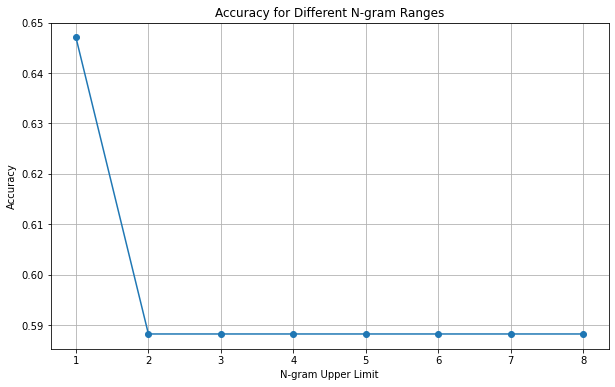

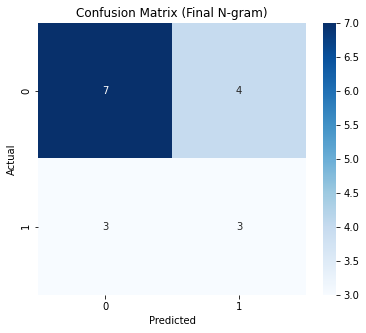

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Load Greek stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('greek')).union(set(string.punctuation))

# GUI class
class TextClassifierApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sleep Text Classifier")

        self.upload_button = tk.Button(root, text="Upload Text File", command=self.upload_file)
        self.upload_button.pack(pady=10)

        self.run_button = tk.Button(root, text="Run Classification", command=self.run_classification, state=tk.DISABLED)
        self.run_button.pack(pady=10)

        self.file_path = None
        self.df = None

    def upload_file(self):
        self.file_path = filedialog.askopenfilename(filetypes=[("Text files", "*.txt")])
        if self.file_path:
            try:
                self.df = pd.read_csv(self.file_path, sep='\t')
                if 'Text' in self.df.columns and 'Label' in self.df.columns:
                    messagebox.showinfo("Success", "File loaded successfully.")
                    self.run_button.config(state=tk.NORMAL)
                else:
                    messagebox.showerror("Error", "File must contain 'Text' and 'Label' columns.")
            except Exception as e:
                messagebox.showerror("Error", str(e))

    def preprocess(self, text):
        tokens = word_tokenize(text)
        return ' '.join([word for word in tokens if word.lower() not in stop_words])

    def run_classification(self):
        try:
            self.df['Text'] = self.df['Text'].apply(self.preprocess)
            X_train, X_test, y_train, y_test = train_test_split(self.df['Text'], self.df['Label'],
                                                                test_size=0.2, random_state=42, shuffle=True)
            n_gram_accuracies = []
            N = 9
            final_pred = None
            final_y_test = None

            for n in range(1, N):
                vectorizer = CountVectorizer(ngram_range=(1, n))
                X_train_vec = vectorizer.fit_transform(X_train)
                X_test_vec = vectorizer.transform(X_test)

                model = MultinomialNB()
                model.fit(X_train_vec, y_train)
                y_pred = model.predict(X_test_vec)

                acc = accuracy_score(y_test, y_pred)
                n_gram_accuracies.append(acc)

                if n == N - 1:  # Save the final prediction for confusion matrix
                    final_pred = y_pred
                    final_y_test = y_test

            # Plot accuracy
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, N), n_gram_accuracies, marker='o')
            plt.title("Accuracy for Different N-gram Ranges")
            plt.xlabel("N-gram Upper Limit")
            plt.ylabel("Accuracy")
            plt.grid(True)
            plt.xticks(range(1, N))
            plt.show()

            # Confusion matrix
            cm = confusion_matrix(final_y_test, final_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix (Final N-gram)")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()

        except Exception as e:
            messagebox.showerror("Error", str(e))

# Main
if __name__ == "__main__":
    root = tk.Tk()
    app = TextClassifierApp(root)
    root.mainloop()
